# Review Helpfulness Classification - BERT-TRI
* Dataset - Amazon(Toys and Games, CDs and Vinyls)
* Features - Cleaned_Review_Text, Review_Rating

In [ ]:
 !pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.6 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, LSTM, Embedding, Dropout, Dense, Flatten, Conv1D, GlobalMaxPool1D, Input, concatenate, MaxPooling1D, GlobalMaxPooling1D, MaxPool1D, Concatenate, Multiply, Attention
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.activations import relu, sigmoid
from transformers import TFBertModel, BertTokenizer, BertConfig
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.backend as K
import random
import nltk
import json
import tqdm
import re, os

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
amzn = pd.read_csv('/datasets/datasets/preprocessed_amazon_Toys_and_Games.csv')
print(amzn.shape)
amzn.head()

(416090, 7)


<ipython-input-3-64067b8b7bee>:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  amzn = pd.read_csv('/content/drive/MyDrive/seminar/bert_review_helpfulness/datasets/datasets/preprocessed_amazon_Toys_and_Games.csv')


,asin,reviewerID,overall,reviewText,vote,helpfulness label,Cleaned_Review_Text
0,B01B55C2JA,A1AWL9JASMG904,3,My son had a blast building this toy. When bui...,2,1,son blast build toy build toy gun length fairl...
1,B00KJLUTQU,A2DQ67Q51HRFAG,5,Excellent Product,2,1,excellent product
2,B00TY41IO0,A3VT4CGFRLSR0B,3,My 4 year old son had to have this. He used a ...,6,1,year old son use gift card get birthday buy su...
3,B00UMA2VSW,A3FS1V5048JF4S,5,Great build. My kids put it together over a f...,3,1,great build kid put together days motor mess s...
4,B00CR60HLM,A3F3WL8WYBCQ2B,4,"Our daughter really ""digs"" this set when we go...",7,1,daughter really dig set beach already manage b...


In [ ]:
# Set Seed
# numpy와 tensorflow 2가지에 seed 설정
# 해당 코드 출처 : https://dacon.io/codeshare/2363

def seed_everything(seed: int=42):
  random.seed(seed)
  np.random.seed(seed)
  os.environ['PYTHONASHSEED'] = str(seed)
  tf.random.set_seed(seed)
my_seed = 42
seed_everything(my_seed)

In [ ]:
amzn_train, amzn_test = train_test_split(amzn, test_size=0.2, shuffle=True, random_state=42, stratify=amzn['helpfulness label'])
train_rating = np.array(amzn_train['overall'])
test_rating = np.array(amzn_test['overall'])

amzn_train_input_ids = np.load(open('/datasets/bert_inputs/amzn_toys_and_games_cleaned_bert_train_input_ids.npy','rb'))
amzn_train_attention_masks = np.load(open('/datasets/bert_inputs/amzn_toys_and_games_cleaned_bert_train_attention_masks.npy','rb'))
amzn_train_type_ids = np.load(open('/datasets/bert_inputs/amzn_toys_and_games_cleaned_bert_train_type_ids.npy','rb'))
amzn_train_labels = np.load(open('/datasets/bert_inputs/amzn_toys_and_games_cleaned_bert_train_label.npy','rb'))

amzn_train_inputs = (amzn_train_input_ids, amzn_train_attention_masks, amzn_train_type_ids)

amzn_test_input_ids = np.load(open('/datasets/bert_inputs/amzn_toys_and_games_cleaned_bert_test_input_ids.npy','rb'))
amzn_test_attention_masks = np.load(open('/datasets/bert_inputs/amzn_toys_and_games_cleaned_bert_test_attention_masks.npy','rb'))
amzn_test_type_ids = np.load(open('/datasets/bert_inputs/amzn_toys_and_games_cleaned_bert_test_type_ids.npy','rb'))
amzn_test_labels = np.load(open('/datasets/bert_inputs/amzn_toys_and_games_cleaned_bert_test_label.npy','rb'))

amzn_test_inputs = (amzn_test_input_ids, amzn_test_attention_masks, amzn_test_type_ids)

In [ ]:
# TPU 작동을 위한 셋업
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)

In [ ]:
# BERT_TRI : BERT with additional attention+multiple layers

class bert_tri(tf.keras.Model):

  def __init__(self, model_name, dir_path, num_class):
    super(bert_tri, self).__init__()
    self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
    self.rating_emb = Embedding(6, 768, embeddings_regularizer=l2(), name='rating_embeddings')
    self.flat = Flatten()
    self.mul = Multiply()
    self.dropout = Dropout(self.bert.config.hidden_dropout_prob)
    self.clf = Dense(num_class,
                     activation='sigmoid',
                     name='classifier')

  def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):

    text_inputs, rating = inputs
    outputs = self.bert(text_inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
    rat = self.rating_emb(rating)
    rat = self.flat(rat)
    bert_output = outputs[1]
    bert_output = self.dropout(bert_output, training=training)

    attention = Attention()([rat, bert_output])
    interaction = Multiply()([bert_output, attention])

    drop_1 = self.dropout(interaction)

    output = self.clf(drop_1)
    return output

In [ ]:
with strategy.scope():
  cls_model = bert_tri(model_name='bert-base-uncased', dir_path='bert_ckpt', num_class=1)
  optimizer = Adam(1e-5)
  loss = tf.keras.losses.BinaryCrossentropy()
  metric = tf.keras.metrics.BinaryAccuracy()
  cls_model.compile(optimizer=optimizer,
                    loss=loss, metrics=[metric])
  es = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3)
  cp = ModelCheckpoint('bert_tri.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
result = cls_model.fit([amzn_train_inputs, train_rating], amzn_train_labels, batch_size=32, epochs=4, validation_split=0.2, callbacks=[es,cp])

Epoch 1/4
8322/8322 [==============================] - ETA: 0s - loss: 0.5547 - binary_accuracy: 0.7396
Epoch 1: val_loss improved from inf to 0.53436, saving model to bert_tri.h5
8322/8322 [==============================] - 1527s 174ms/step - loss: 0.5547 - binary_accuracy: 0.7396 - val_loss: 0.5344 - val_binary_accuracy: 0.7472
Epoch 2/4
8322/8322 [==============================] - ETA: 0s - loss: 0.5232 - binary_accuracy: 0.7498
Epoch 2: val_loss improved from 0.53436 to 0.52214, saving model to bert_tri.h5
8322/8322 [==============================] - 1434s 172ms/step - loss: 0.5232 - binary_accuracy: 0.7498 - val_loss: 0.5221 - val_binary_accuracy: 0.7484
Epoch 3/4
8322/8322 [==============================] - ETA: 0s - loss: 0.4991 - binary_accuracy: 0.7649
Epoch 3: val_loss did not improve from 0.52214
8322/8322 [==============================] - 1429s 172ms/step - loss: 0.4991 - binary_accuracy: 0.7649 - val_loss: 0.5244 - val_binary_accuracy: 0.7450
Epoch 4/4
8322/8322 [========

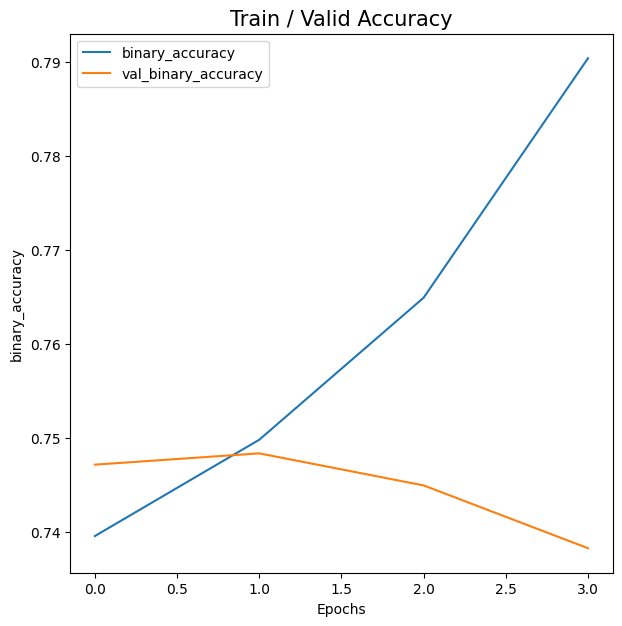

2601/2601 [==============================] - 145s 54ms/step
F1-Score : [0.7485160887222743]
Precision : [0.7217189522067027]
Recall : [0.7773798937729818]


In [ ]:
def draw_plot(history,metric):
  plt.figure(figsize=(7,7))
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric])
  plt.title('Train / Valid Accuracy',fontsize=15)
  plt.ylabel(metric)
  plt.xlabel('Epochs')
  plt.legend([metric, 'val_'+metric])
  plt.show()

draw_plot(result, 'binary_accuracy')

f1_score_list = []
precision_list = []
recall_list = []

y_pred = cls_model.predict([amzn_test_inputs, test_rating])
idx = 0

for k in y_pred:
  if k >= 0.5:
    y_pred[idx] = 1
  else:
    y_pred[idx] = 0
  idx += 1

f1_score_list.append(f1_score(amzn_test_labels, y_pred))
precision_list.append(precision_score(amzn_test_labels, y_pred))
recall_list.append(recall_score(amzn_test_labels, y_pred))

#print(cls_model.evaluate([amzn_test_inputs, test_rating], amzn_test_labels, batch_size=32))
print(f'F1-Score : {f1_score_list}')
print(f'Precision : {precision_list}')
print(f'Recall : {recall_list}')

In [ ]:
cls_model.save_weights('bert_tri_model.h5')

In [ ]:
cls_model.built = True
cls_model.load_weights('/content/drive/MyDrive/seminar/bert_review_helpfulness/datasets/bert_inputs/bert_tri_tg.h5', by_name=True, skip_mismatch = True)

In [ ]:
y_pred = cls_model.predict([amzn_test_inputs, test_rating])
idx = 0

for k in y_pred:
  if k >= 0.5:
    y_pred[idx] = 1
  else:
    y_pred[idx] = 0
  idx += 1

f1_score_list, precision_list, recall_list = [], [], []

f1_score_list.append(f1_score(amzn_test_labels, y_pred))
precision_list.append(precision_score(amzn_test_labels, y_pred))
recall_list.append(recall_score(amzn_test_labels, y_pred))

#print(cls_model.evaluate([amzn_test_inputs, test_rating], amzn_test_labels, batch_size=32))
print(f'F1-Score : {f1_score_list}')
print(f'Precision : {precision_list}')
print(f'Recall : {recall_list}')

2601/2601 [==============================] - 153s 54ms/step
F1-Score : [0.7489456265905208]
Precision : [0.7446661914944167]
Recall : [0.7532745319522218]
